<a href="https://colab.research.google.com/github/katearb/ipynb-projects/blob/master/w8_TimeSeries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyramid-arima

In [ ]:
!pip install prophet

In [ ]:
!pip install catboost

In [ ]:
!pip install bds_courseware
from bds_courseware import read_drive_dataset
from bds_courseware import print_dataset_description, print_module_datasets
from bds_courseware import HOMEWORK_DATASETS
name = 'bike_sharing_hour'

In [ ]:
from itertools import product

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as st
from scipy.fft import fft

from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf

from sklearn.model_selection import TimeSeriesSplit as tscv, train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error as mae, mean_squared_error as mse
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder

from prophet import Prophet
from catboost import CatBoostRegressor

import warnings
warnings.filterwarnings('ignore')

In [ ]:
sns.set_theme()
sns.set(font_scale = 1.25)

FONT_SIZE=14
plt.rcParams["figure.figsize"] = (18, 8)

In [ ]:
from datetime import timedelta

In [ ]:
import random
random.seed(12)

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = read_drive_dataset(*HOMEWORK_DATASETS[name])
df.set_index('instant', inplace=True)

In [ ]:
df

dteday  season  yr  mnth  ...  windspeed  casual  registered  cnt
instant                                ...                                    
1        2011-01-01       1   0     1  ...     0.0000       3          13   16
2        2011-01-01       1   0     1  ...     0.0000       8          32   40
3        2011-01-01       1   0     1  ...     0.0000       5          27   32
4        2011-01-01       1   0     1  ...     0.0000       3          10   13
5        2011-01-01       1   0     1  ...     0.0000       0           1    1
...             ...     ...  ..   ...  ...        ...     ...         ...  ...
17375    2012-12-31       1   1    12  ...     0.1642      11         108  119
17376    2012-12-31       1   1    12  ...     0.1642       8          81   89
17377    2012-12-31       1   1    12  ...     0.1642       7          83   90
17378    2012-12-31       1   1    12  ...     0.1343      13          48   61
17379    2012-12-31       1   1    12  ...     0.1343      12          37   49

[17379 rows x 16 columns]

# EDA FROM PREVIOUS SECTION

In [ ]:
# general info
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17379 entries, 1 to 17379
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dteday      17379 non-null  object 
 1   season      17379 non-null  int64  
 2   yr          17379 non-null  int64  
 3   mnth        17379 non-null  int64  
 4   hr          17379 non-null  int64  
 5   holiday     17379 non-null  int64  
 6   weekday     17379 non-null  int64  
 7   workingday  17379 non-null  int64  
 8   weathersit  17379 non-null  int64  
 9   temp        17379 non-null  float64
 10  atemp       17379 non-null  float64
 11  hum         17379 non-null  float64
 12  windspeed   17379 non-null  float64
 13  casual      17379 non-null  int64  
 14  registered  17379 non-null  int64  
 15  cnt         17379 non-null  int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 2.3+ MB


In [ ]:
print(f"We have {df.duplicated().sum()} duplicates.")

We have 0 duplicates.


In [ ]:
print("\nNans in the dataframe:")
display(df.isna().sum())


Nans in the dataframe:


dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

Most of the features seem to be numeric. However, from the data description, we find out that many features are categorical ones.

## Univariate analysis

In [ ]:
def draw_distr(feature, title='', bins='auto'):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))

  sns.distplot(x=feature, bins=bins, ax=ax1)
  ax1.set_title(f'Distribution of {title}')

  sns.boxplot(x=feature, ax=ax2)
  ax2.set_title(f'Boxplot of {title}')

  plt.show()

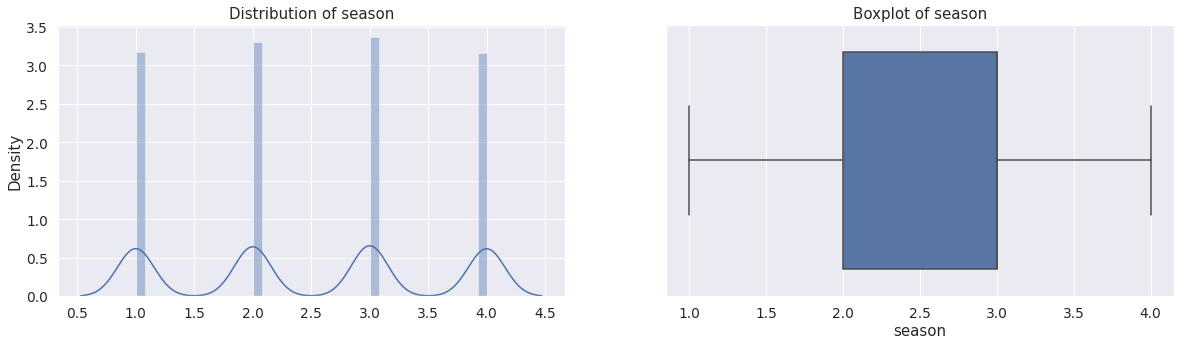

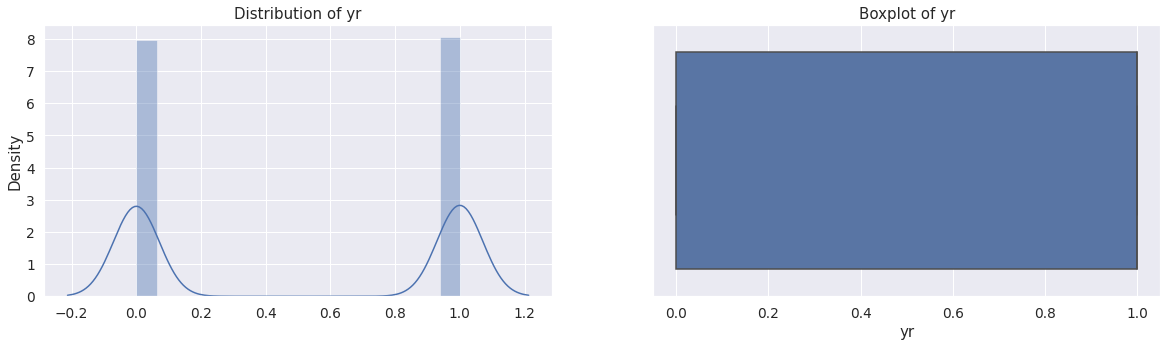

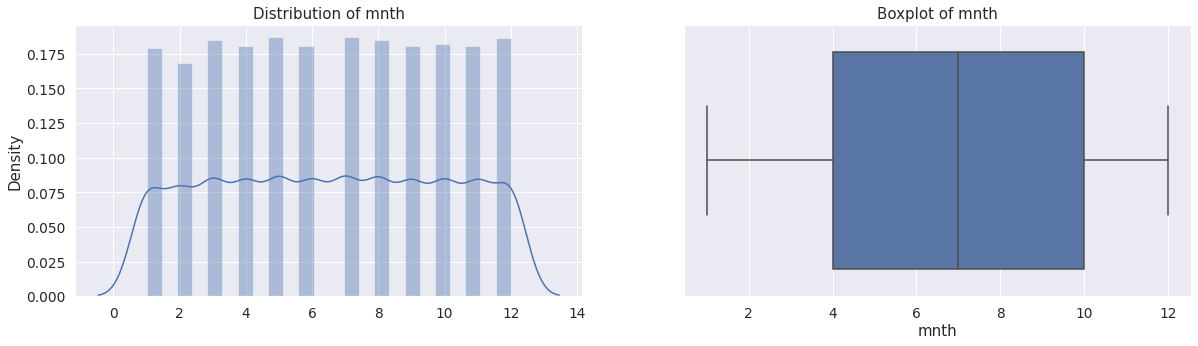

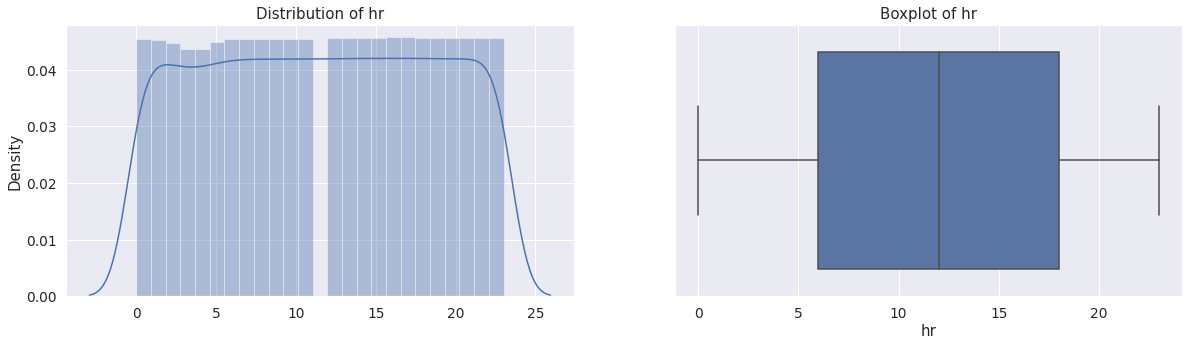

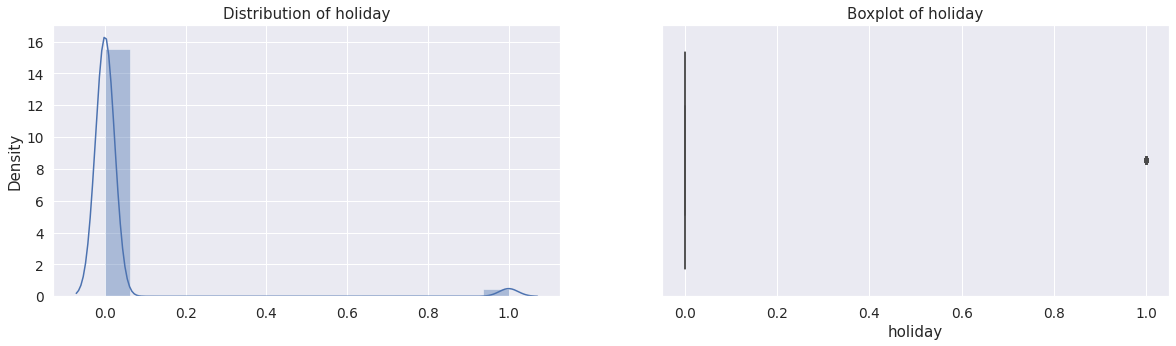

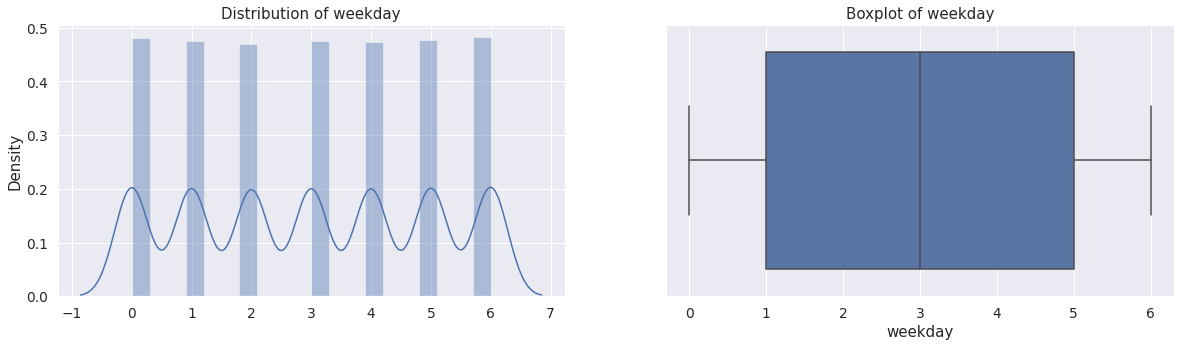

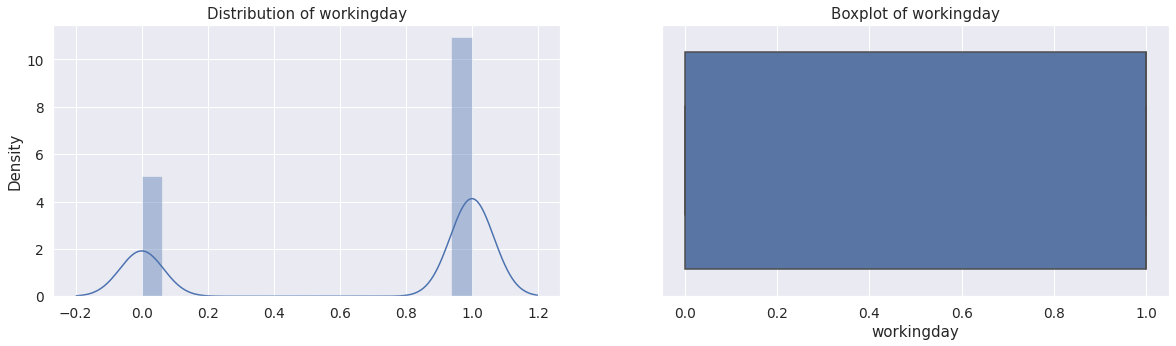

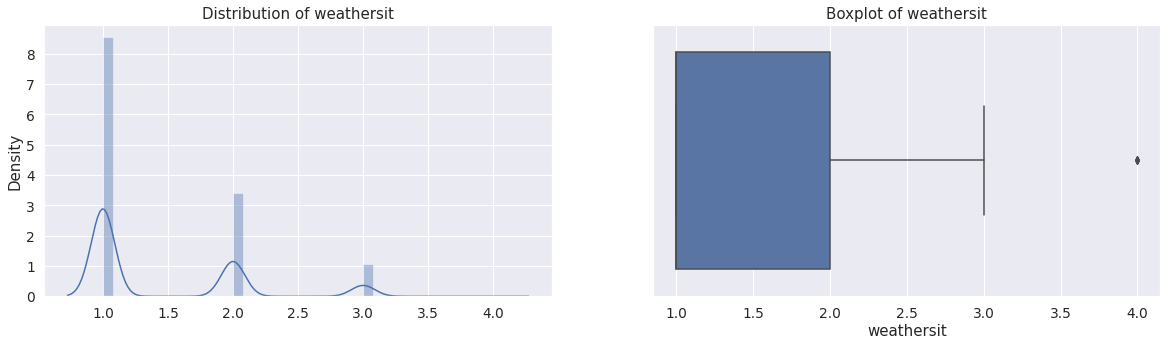

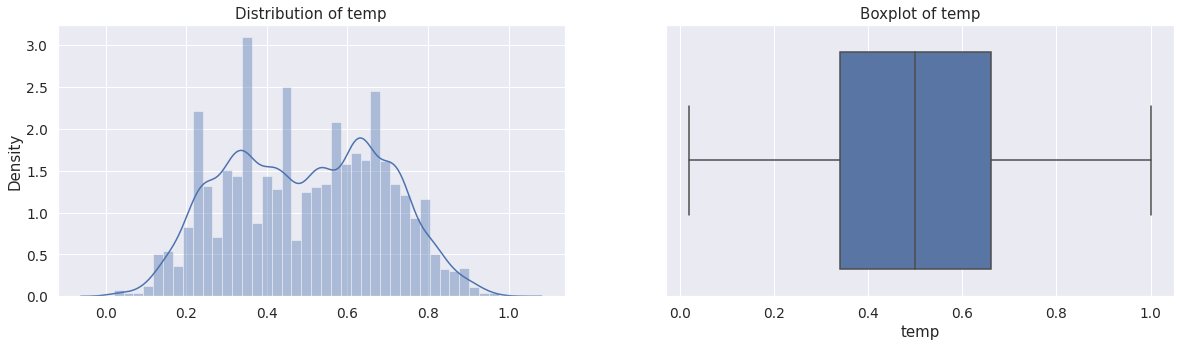

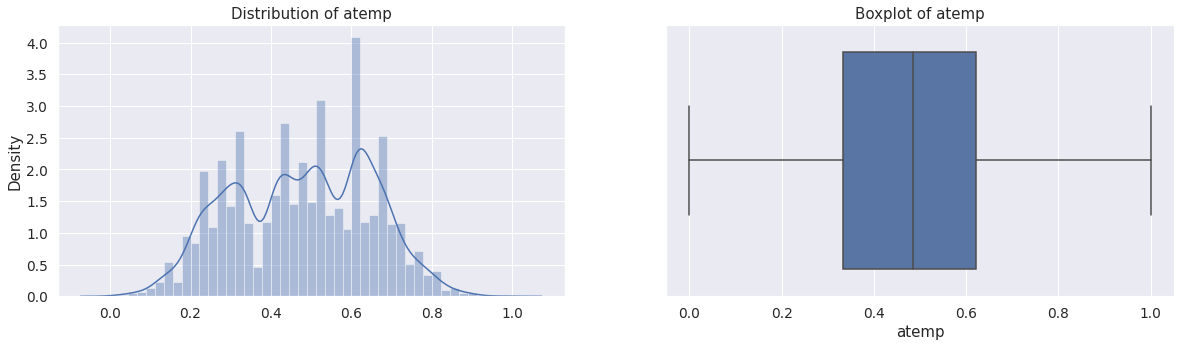

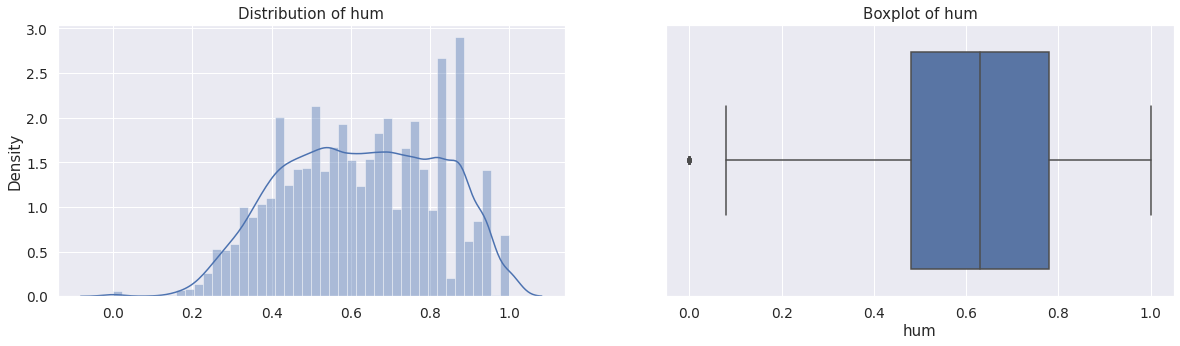

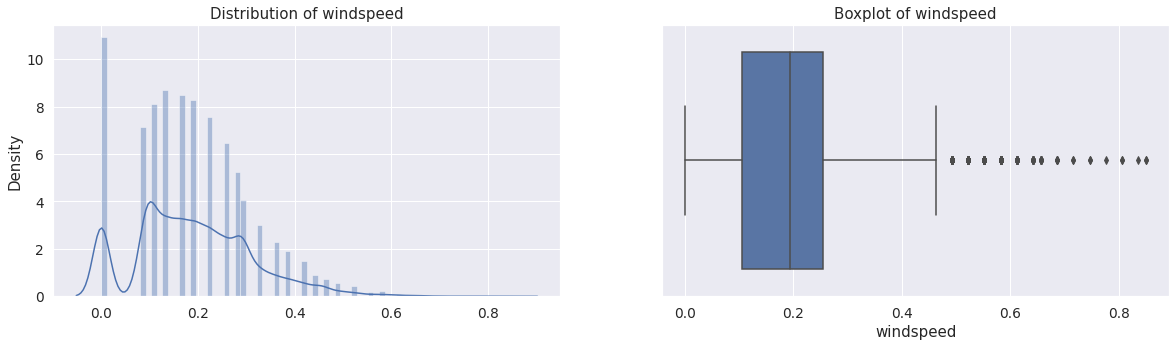

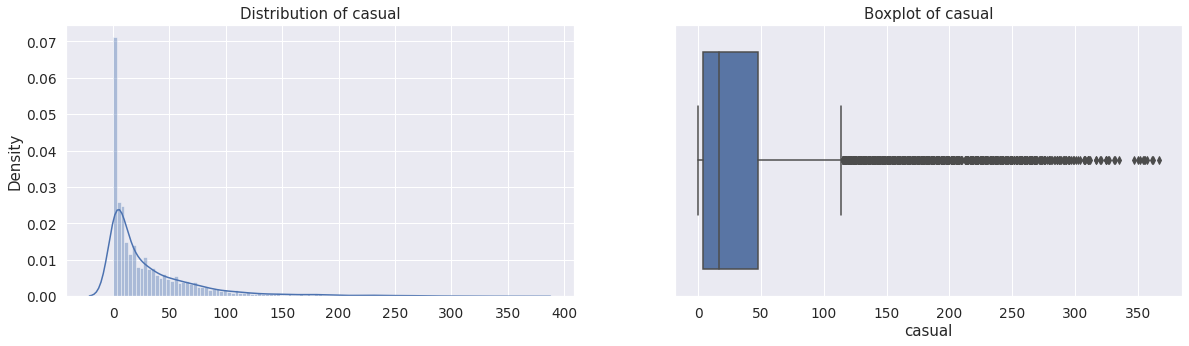

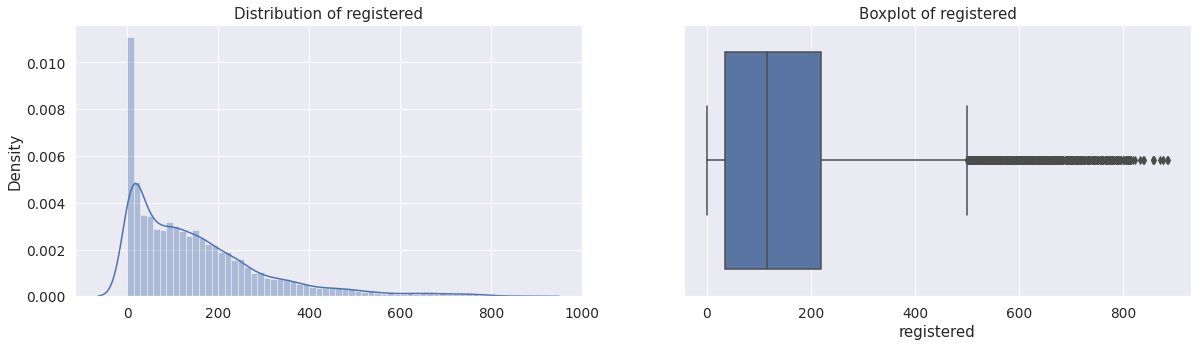

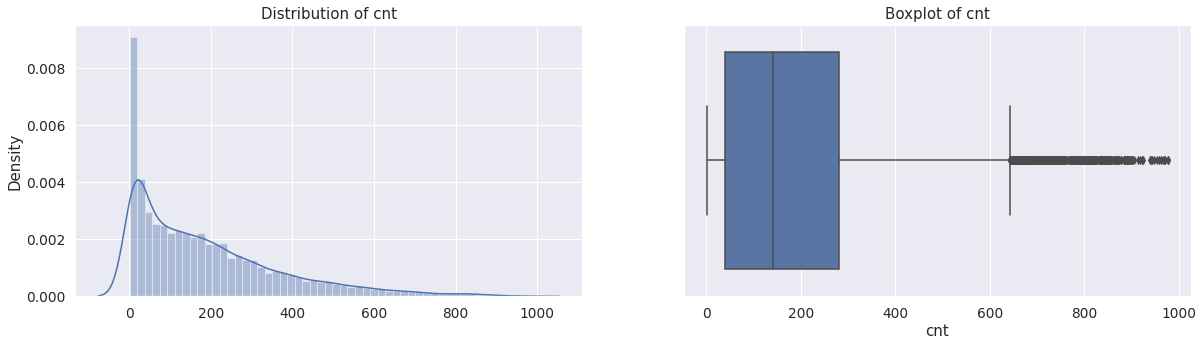

In [ ]:
for col in df.columns[1:]:
  draw_distr(df[col], col)

### Observations:
1. Most of the feature are whether categorical or binary. --> encoding is needed
2. Those features which are numeric by their nature (temperature, feeling temperature, humidity, windspeed) are already normalized.
3. Temp has a symmetric distribution, but unlike to normal distribution it has two modes --> maping to normal distribution is needed.
4. Atemp is also symmetric and has several modes. --> maping to normal distribution is needed.
5. Hum has negative kurtosis and is a bit skewed to the left.
6. The wind speed has a lot of 0 values. The other values are distributed with positive skewness.
7. The target is numeric and not normalized. Its distribution is skewed positively.

### Univariate analysis of categorical features

In [ ]:
cat = ['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit']
num = ['temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered']
target = 'cnt'

In [ ]:
def draw_pie(feature, title=''):
  pie_info = feature.value_counts()
  plt.figure(figsize=(5, 5))
  plt.pie(pie_info, labels=pie_info.index)
  plt.title(title)
  plt.show()

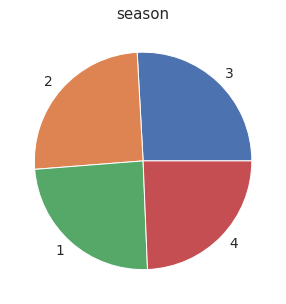

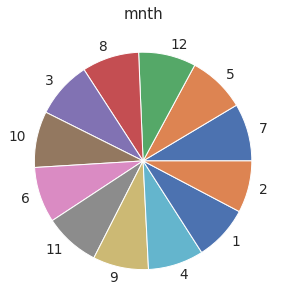

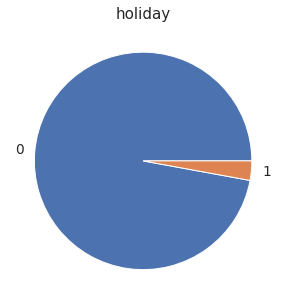

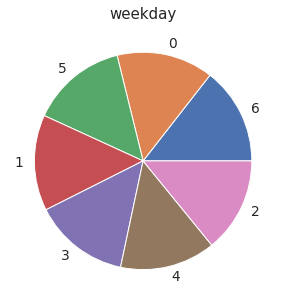

In [ ]:
for col in cat:
  draw_pie(df[col], col)

For sure, features which represent calendar units (like year, month, weekday) are equally distributed over their values. Holiday feature has low variance.

Talking about the weather, I can say that it is mostly sunny in Washington and heavy rain hardly ever can be seen there. What good conditions for bicycles!

## Multivariate analysis

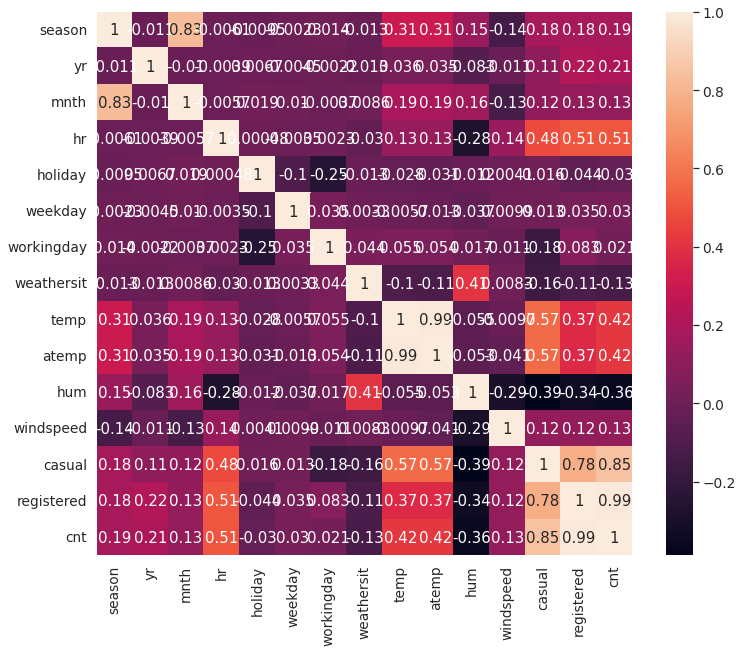

In [ ]:
# correlation
df_corr = df.corr('spearman')
plt.figure(figsize=(12, 10))
sns.heatmap(df_corr, annot=True)
plt.show()

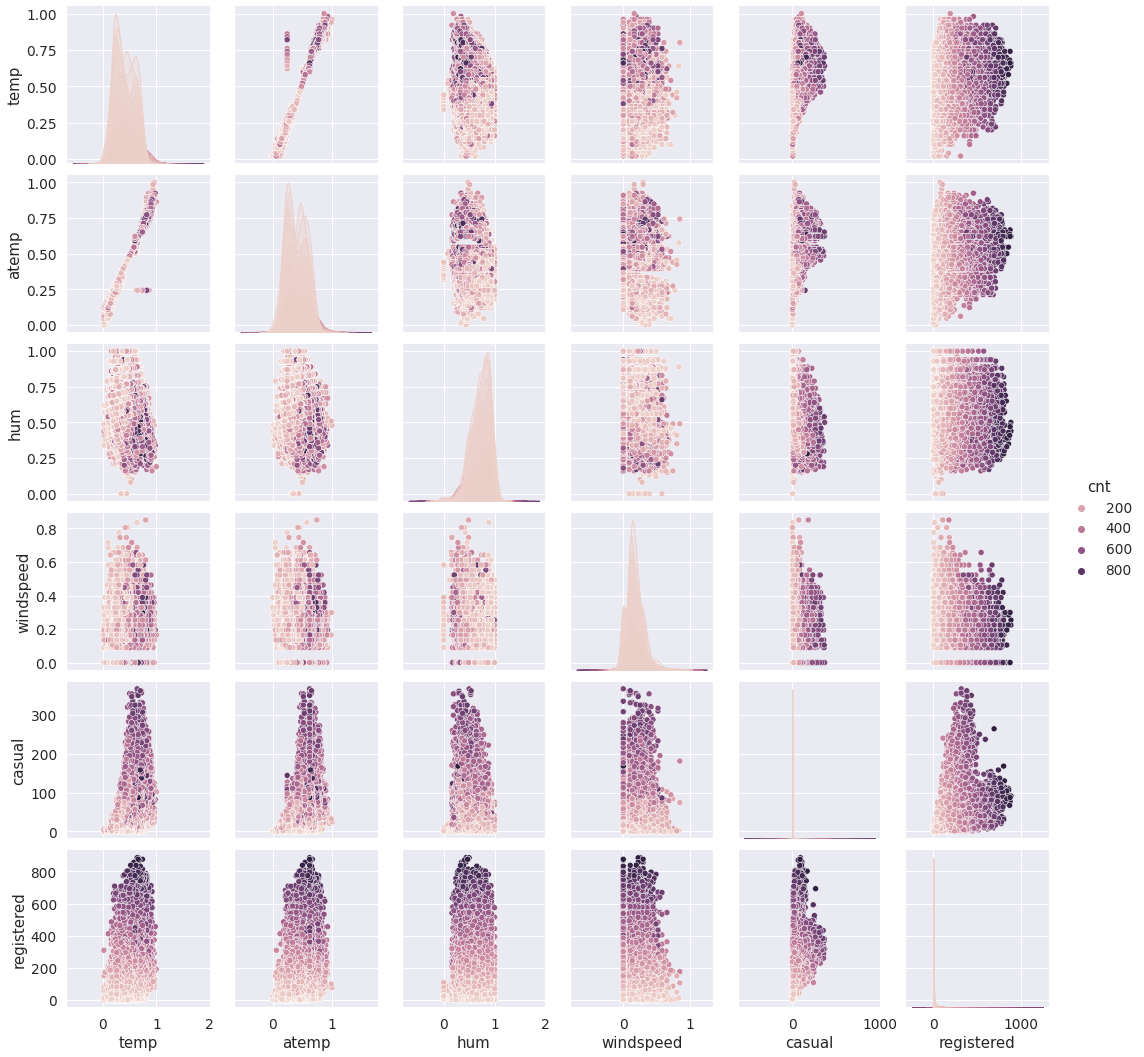

In [ ]:
sns.pairplot(df[num +[target]], hue=target)
plt.show()

Multicorrelation between some features is observed:
  * Between time-related features: month-season
  * between seasom and temperatures
  * between weather rate and humidity, as weathersit reflects rain aswell
  * between target related features.

Target is mostly correlated with hour, temperatures, humidity (negatively), year and season.

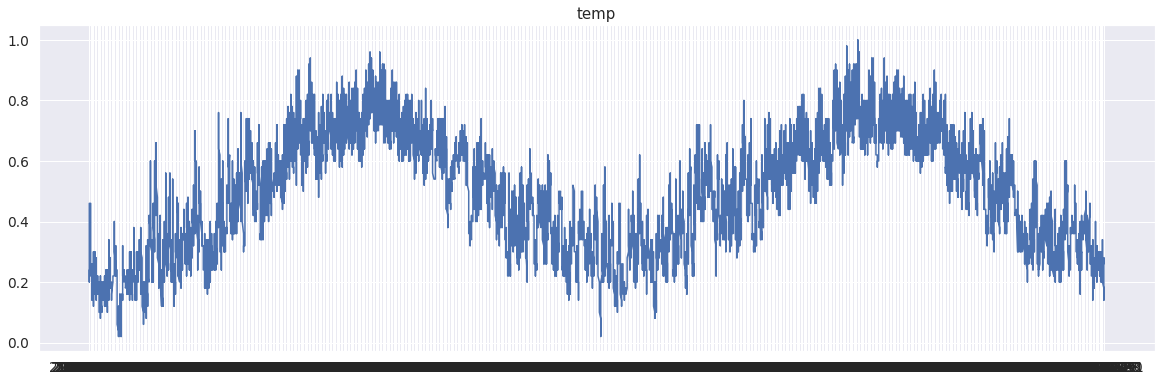

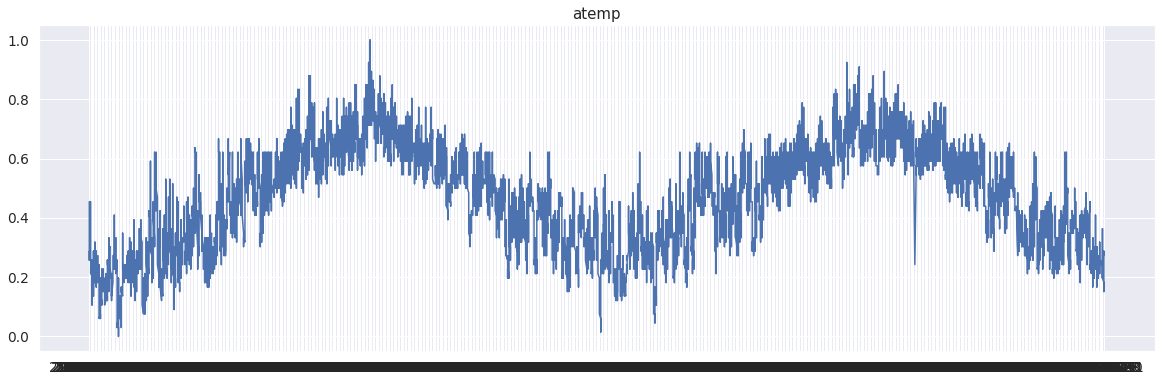

In [ ]:
for feature in num + [target]:
  plt.figure(figsize=(20, 6))
  plt.plot(df['dteday'], df[feature])
  plt.title(feature)
  plt.show()

# EDA FOR TIME SERIES

In [ ]:
date_time  = []
for d, t in zip(df['dteday'], df['hr']):
  if t < 10:
    date_time.append(np.datetime64(f'{d} 0{t}:00:00'))
  else:
    date_time.append(np.datetime64(f'{d} {t}:00:00'))

In [ ]:
df['date_time'] = date_time

In [ ]:
df_time = df[['date_time', 'cnt']]
df_time = df_time.set_index(pd.DatetimeIndex(df_time['date_time']))
df_time.drop(['date_time'], axis=1, inplace=True)

In [ ]:
df_time

cnt
date_time               
2011-01-01 00:00:00   16
2011-01-01 01:00:00   40
2011-01-01 02:00:00   32
2011-01-01 03:00:00   13
2011-01-01 04:00:00    1
...                  ...
2012-12-31 19:00:00  119
2012-12-31 20:00:00   89
2012-12-31 21:00:00   90
2012-12-31 22:00:00   61
2012-12-31 23:00:00   49

[17379 rows x 1 columns]

### Test for stationarity

In [ ]:
def test_adf(data, alpha=0.05):
  print("==== Augmented Dickey–Fuller (Null hypothesis - The process is non-stationary): ")

  result = adfuller(data, autolag='AIC')
  print(f'ADF Statistic: {result[0]}')
  print(f'p-value: {result[1]}')

  if result[1] < alpha:
    print("The process is stationary.\n")
  else:
    print("The process is non-stationary.\n")

def test_kpss(data, alpha=0.05):
  print('==== Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test (Null hypothesis - The process is stationary):')

  kpsstest = kpss(data, regression='c')
  print("KPSS Statistic = " + str(kpsstest[0]))
  print( "p-value = " +str(kpsstest[1]))

  if kpsstest[1] < alpha:
    print("The process is non-stationary.\n")
  else:
    print("The process is stationary.\n")

In [ ]:
plt.figure(figsize=(20, 6))
df_time['cnt'].plot()
plt.title('cnt')
plt.show()

From the graph, it gets clear that target is differently distributed depending on the year.

In [ ]:
test_adf(df_time['cnt'])

==== Augmented Dickey–Fuller (Null hypothesis - The process is non-stationary): 
ADF Statistic: -6.8229187118950945
p-value: 1.980862627797809e-09
The process is stationary.



In [ ]:
test_kpss(df_time['cnt'])

==== Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test (Null hypothesis - The process is stationary):
KPSS Statistic = 18.05444985761808
p-value = 0.01
The process is non-stationary.



Wow, we have got a contoversial case -- out tests showed opposite results. It can be explaned by the following: the ADF test has an alternate hypothesis of **linear or difference** stationary, while the KPSS test identifies **trend**-stationarity in a series.

As we have KPSS = not stationary and ADF = stationary,  **difference** stationary is observed in the data --> we should use differencing to make series stationary.

## Decomposition

In [ ]:
decomposition = seasonal_decompose(df_time['cnt'].dropna(), model='additive', period=24)

plt.subplots(3, 1, figsize=(30, 21))

plt.subplot(3, 1, 1)
plt.plot(decomposition.trend, 
         '-d', color='navy', markersize=5, label='trend')
plt.plot(df_time, '-bo', markersize=3, label='full data', alpha=0.5)

plt.plot([decomposition.trend.index[0], decomposition.trend.index[-1]], [0, 0])
plt.legend()
plt.grid(linestyle=':', color='k')
plt.title("Trend")

plt.subplot(3, 1, 2)
plt.plot(decomposition.seasonal[:1000], 
         '-gd', markersize=3, label='seasonal')
plt.plot([decomposition.seasonal[:1000].index[0], decomposition.seasonal[:1000].index[-1]], 
         decomposition.seasonal[:1000].mean()*np.array([1, 1]), '--k', 
         label=f"mean = {decomposition.seasonal[:1000].mean():.3g}")
plt.legend()
plt.grid(linestyle=':', color='k')
plt.title(f"Seasonal : range={(decomposition.seasonal.max() - decomposition.seasonal.min()):.3g}")


plt.subplot(3, 1, 3)
plt.plot(decomposition.resid, '-o', color='maroon', markersize=3)
plt.grid(linestyle=':', color='k')
plt.title("Residuals")
plt.show()

Trend seems to be positive with a small coefficient till 2012-10. After that day, negative trend is observed. (It will be reaserched more precisely later)

Some pattern is obsered in residuals which is connected with a year. The range of residuals is the smallest on the boundary between 2011 and 2012. The residuals are also not random within 1 year: in 2011, the variance of residuals is smaller in average compared to 2012. There is also a periodic pattern in the beginning of 2011.

The range of the seasonal component is 168. Seasonal component itself is assymetic: it goes by ~100 up, and by ~70 down.

### Analysis of decomposition residuals

#### Tests for trend stationality

In [ ]:
trend = decomposition.trend.dropna()

In [ ]:
test_adf(trend.dropna())
test_kpss(trend.dropna())

==== Augmented Dickey–Fuller (Null hypothesis - The process is non-stationary): 
ADF Statistic: -5.323668065420477
p-value: 4.890211549771519e-06
The process is stationary.

==== Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test (Null hypothesis - The process is stationary):
KPSS Statistic = 18.5956280510173
p-value = 0.01
The process is non-stationary.



We have got the same results as for the full data --> apply differencing to make it stationary.

In [ ]:
trend_diff = trend.diff().dropna()

plt.subplots(1, 1, figsize=(20, 8))

plt.plot(trend_diff, '-d', color='navy', markersize=3, label='trend')
plt.plot([trend_diff.index[0], trend_diff.index[-1]], [0, 0], '--k')
plt.legend()
plt.grid(linestyle=':', color='k')
plt.title("1st derivative of trend")

Text(0.5, 1.0, '1st derivative of trend')

In [ ]:
# check
test_adf(trend_diff.dropna())
test_kpss(trend_diff.dropna())

==== Augmented Dickey–Fuller (Null hypothesis - The process is non-stationary): 
ADF Statistic: -24.39912454598865
p-value: 0.0
The process is stationary.

==== Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test (Null hypothesis - The process is stationary):
KPSS Statistic = 0.01885727217205669
p-value = 0.1
The process is stationary.



### Residual analysis

In [ ]:
resid = decomposition.resid

plt.subplots(1, 2, figsize=(24, 8))

plt.subplot(1, 2, 1)
plt.plot(resid, '-', color= 'maroon')
plt.grid(linestyle=':', color='k')
plt.title("Residuals")



x_fit = np.linspace(resid.min(), resid.max(), 201)
loc_laplace, scale_laplace = st.laplace.fit(resid.dropna())
loc_norm, scale_norm = st.norm.fit(resid.dropna())
# print(f"Fitting of residuals by Laplace distribution: fitted mean = {loc:.3f}, fitted std = {scale:.3f}")
y_fit_laplace = st.laplace.pdf(x_fit, loc_laplace, scale_laplace)
y_fit_norm = st.norm.pdf(x_fit, loc_norm, scale_norm)

plt.subplot(1, 2, 2)
sns.distplot(resid, color= 'maroon', bins=100, vertical=True, label="distribution of residuals")
plt.plot(y_fit_laplace, x_fit, '-b', 
         label=f"approximation by Laplace distribution:\n  fitted mean = {loc_laplace:.4g}, fitted std = {scale_laplace:.4g}")
plt.plot(y_fit_norm, x_fit, '-g', 
         label=f"approximation by normal distribution:\n  fitted mean = {loc_norm:.4g}, fitted std = {scale_norm:.4g}")
plt.legend()

plt.title("Distribution of residuals")
plt.grid(linestyle=':', color='k')

plt.show()

The distribution' peak tends to look more like by Laplace, the left and right sides -- more like normal

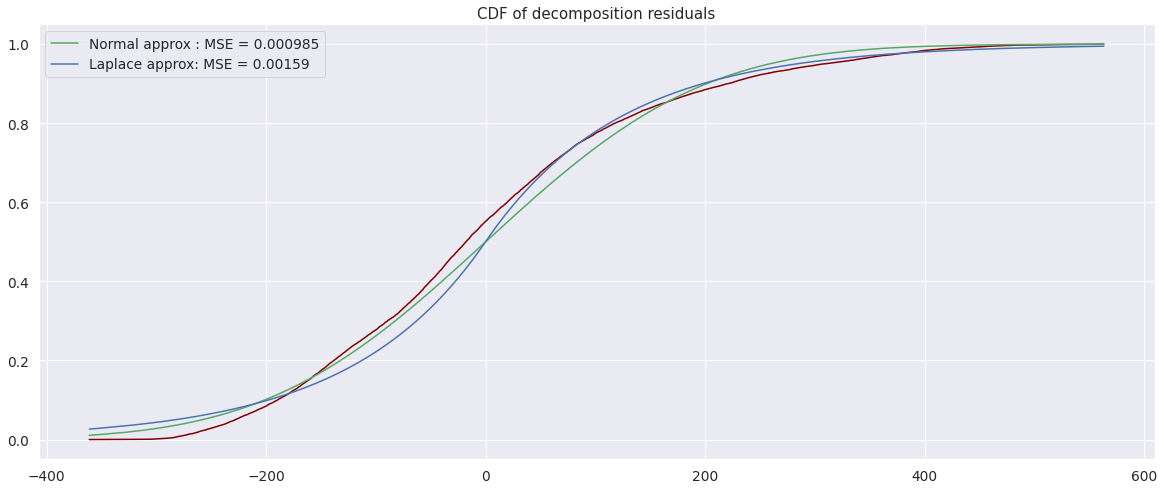

0.6209238041653148


In [ ]:
ecdf_resid_instance = ECDF(resid.dropna())
resid_arr = resid.dropna().sort_values().values
ecdf_resid = ecdf_resid_instance(resid_arr)


cdf_norm = st.norm.cdf(resid_arr, loc=loc_norm, scale=scale_norm)
cdf_laplace = st.laplace.cdf(resid_arr, loc=loc_laplace, scale=scale_laplace)


mse_norm = mse(ecdf_resid, cdf_norm)
mse_laplace = mse(ecdf_resid, cdf_laplace)


plt.subplots(1, 1, figsize=(20, 8))
plt.plot(resid_arr, ecdf_resid, '-', color='maroon')
plt.plot(resid_arr, cdf_norm, '-g', 
         label=f"Normal approx : MSE = {mse_norm:.3g}")
plt.plot(resid_arr, cdf_laplace, '-b', 
         label=f"Laplace approx: MSE = {mse_laplace:.3g}")
plt.legend()
plt.title("CDF of decomposition residuals")
plt.show()

print(mse_norm/mse_laplace)

The errors more tend to have normal distribution. Although the difference between the two numbers is not great.

#### Autocorrelation of residuals


In [ ]:
def plot_autocorrelation(data, lags=300):
  decomposition = seasonal_decompose(data, model='additive', period=24)
  plot_acf(decomposition.resid.dropna(), lags=lags, color='maroon', 
          title='Autocorrelation of residuals')
  plt.grid(linestyle=':', color='k')
  plt.show()

  plot_pacf(decomposition.resid.dropna(), lags=lags, color='maroon', 
          title='Partial autocorrelation of residuals')
  plt.grid(linestyle=':', color='k')
  plt.show()

In [ ]:
def test_Ljung_Box(data):
  print('===H0: The residuals are independently distributed===')
  print('ACF')
  _, _, _, pval = acf(data, unbiased=True,
                                      nlags=30, qstat=True, alpha=0.05)
  
  print('Null hypothesis is rejected for lags:',
  np.where(pval<=0.05))

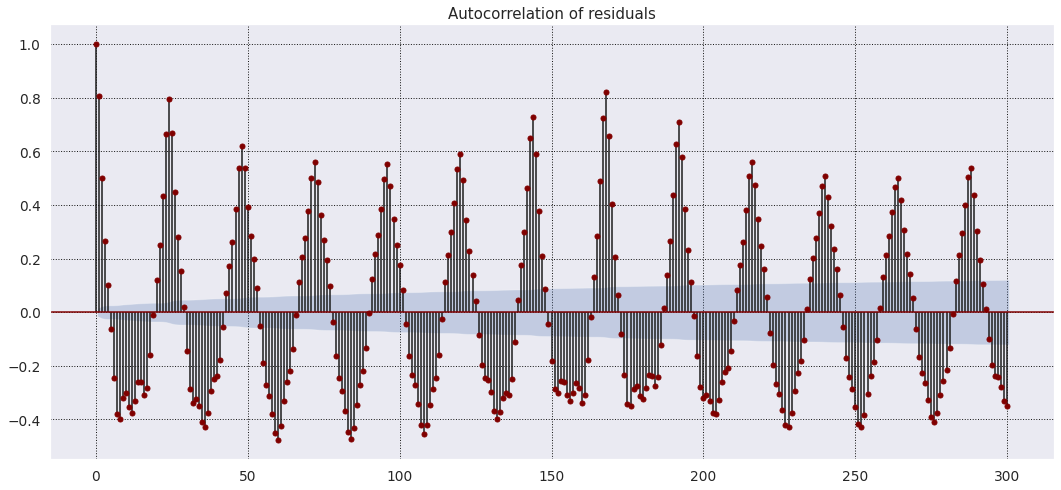

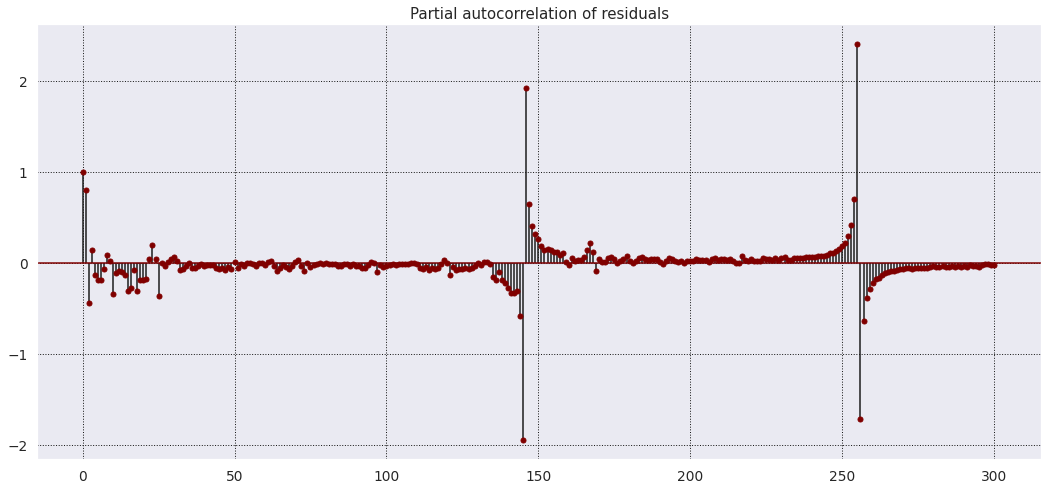

In [ ]:
plot_autocorrelation(df_time['cnt'])

In [ ]:
test_Ljung_Box(df_time['cnt'])

===H0: The residuals are independently distributed===
ACF
Null hypothesis is rejected for lags: (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),)


24-hours periodicity is seen on the graph. That means that applying Fourier transform makes sense. However, I have already stated that differencing is the choice based on the tests. In order not to contradict myself, I will perform both transformations (differencing and Fourier transform) and see which one works better in this very case.

#### Differencing

When a time series exhibits seasonality of a known time period of m time indices, it can be
stationarized by taking seasonal differences between x(t) and x(t-m).

In this case, m = 24.

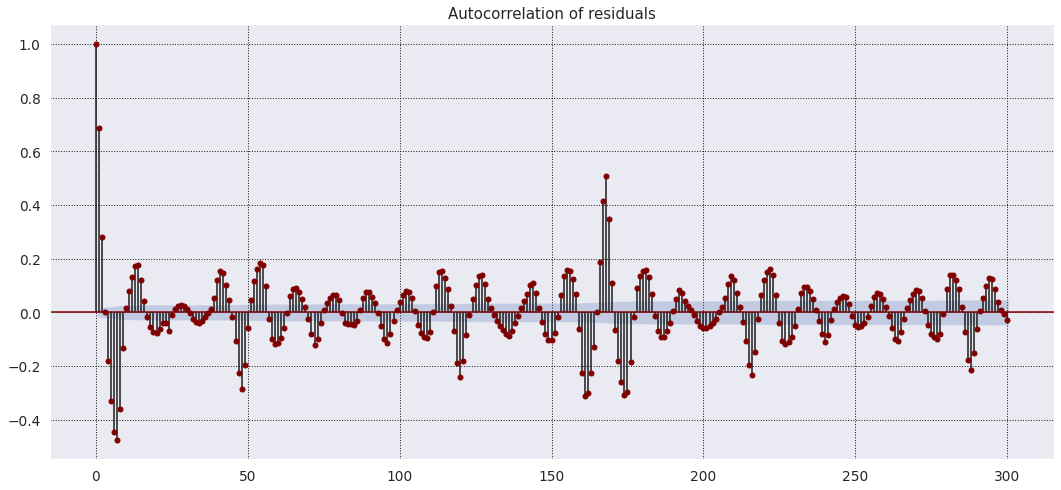

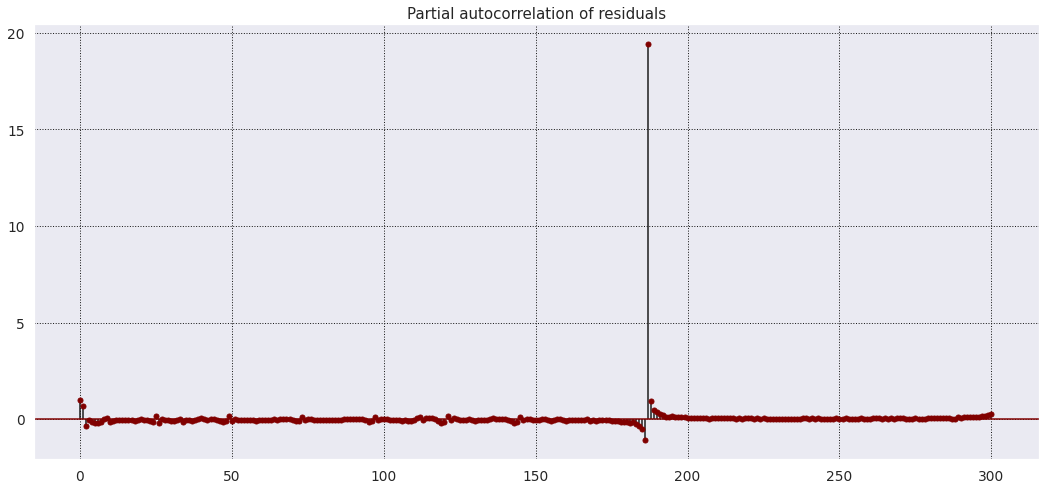

===H0: The residuals are independently distributed===
ACF
Null hypothesis is rejected for lags: (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),)


In [ ]:
target_diff = df_time['cnt'].diff(24).dropna()
plot_autocorrelation(target_diff)
test_Ljung_Box(target_diff)

Differencing reduced the coefs of autocorrelation, but still Ljung_Box's test fails.

#### Fourier transform

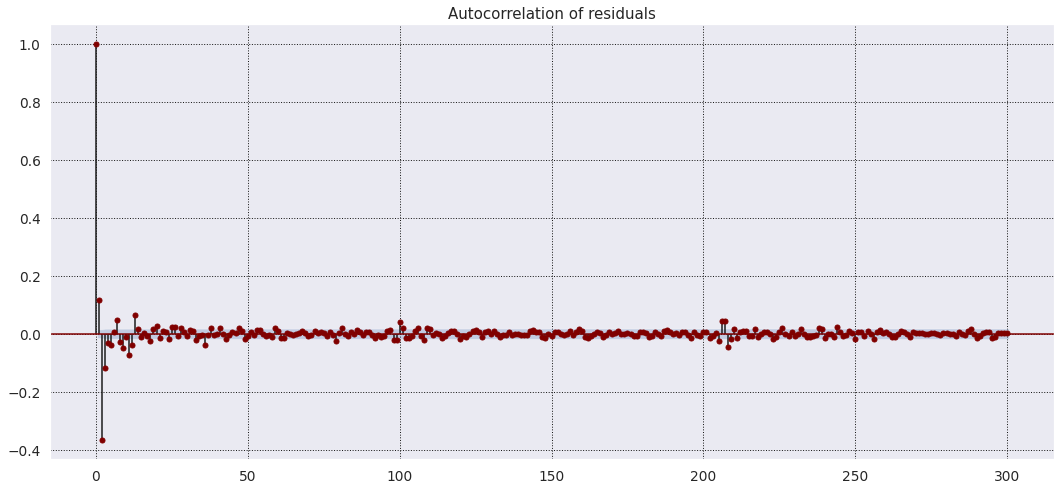

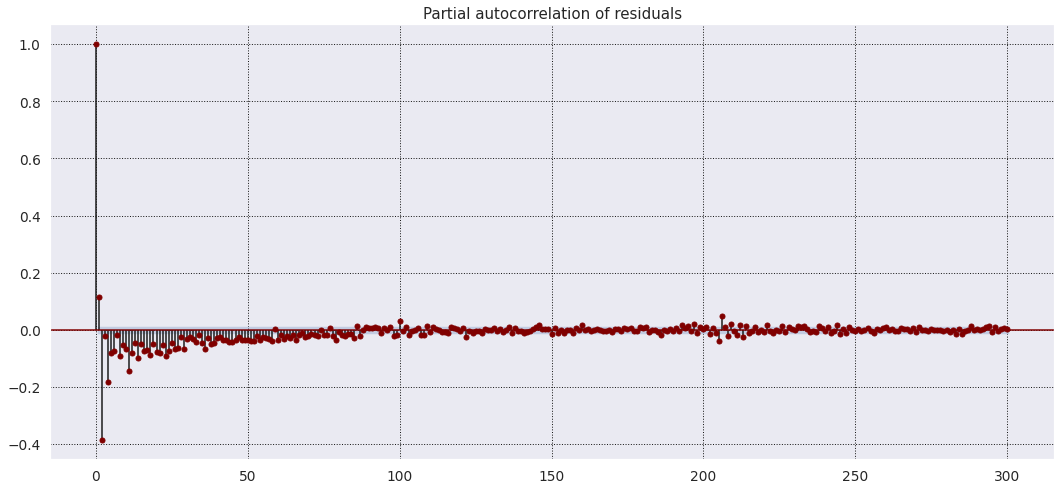

===H0: The residuals are independently distributed===
ACF
Null hypothesis is rejected for lags: (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),)


In [ ]:
target_fft = pd.Series(fft(df_time['cnt']), index=df_time.index)
plot_autocorrelation(target_fft)
test_Ljung_Box(target_fft)

FFT reduced the coefs of autocorrelation even better than differencing, but Ljung_Box's test fails anyway :(
  
  So, residuals cannot be described as "white noise".
  Despite the fact that FFT managed  the job better than differencing (in my opinion), the later will be used for ARIMA, as it cannot handle complex values.

### Correlation analysis

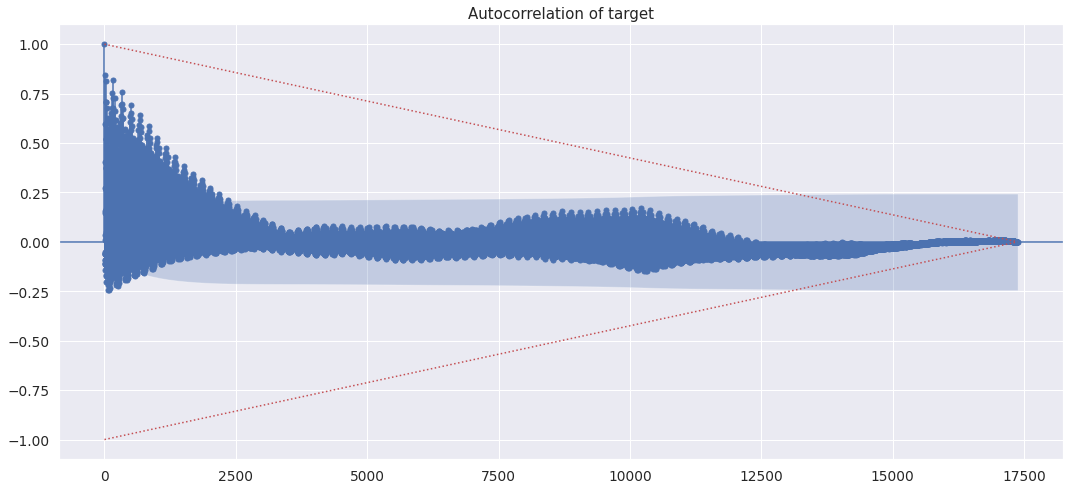

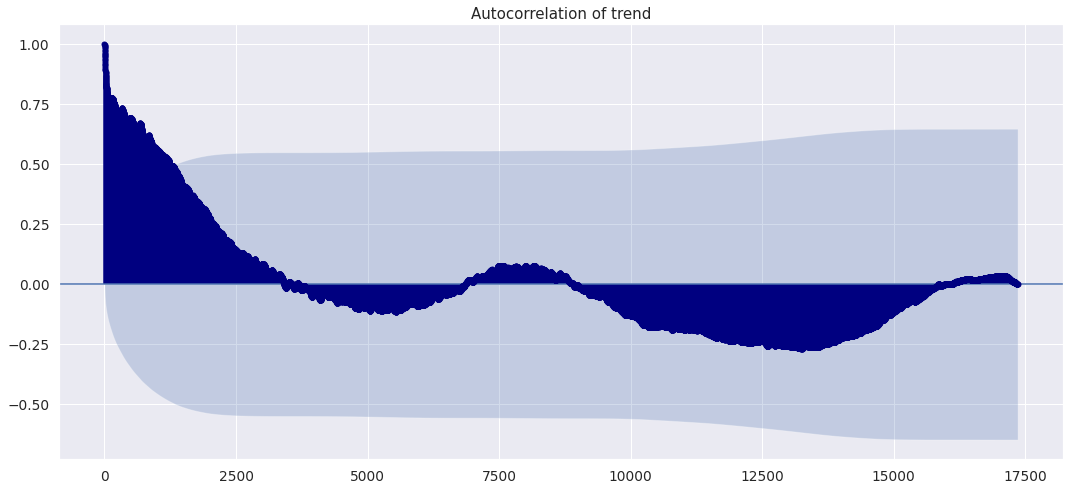

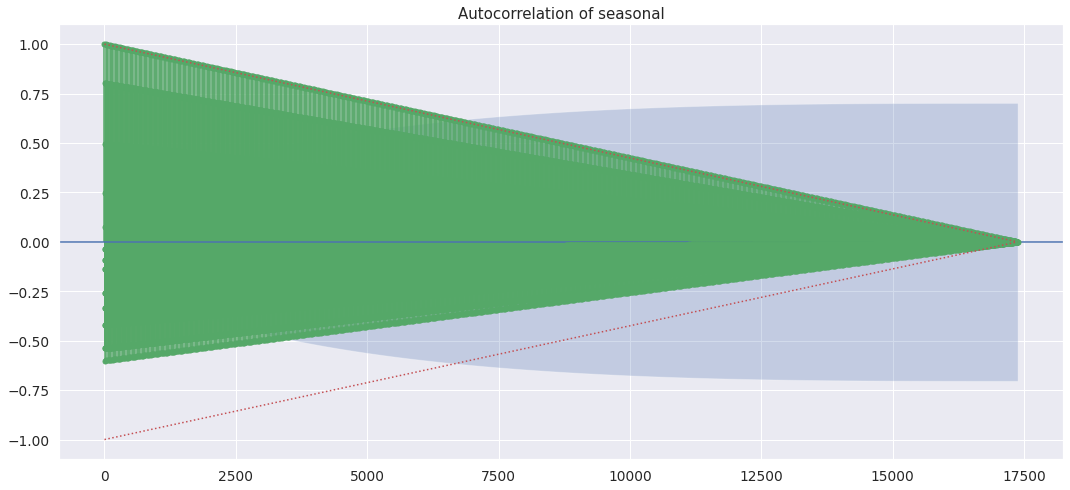

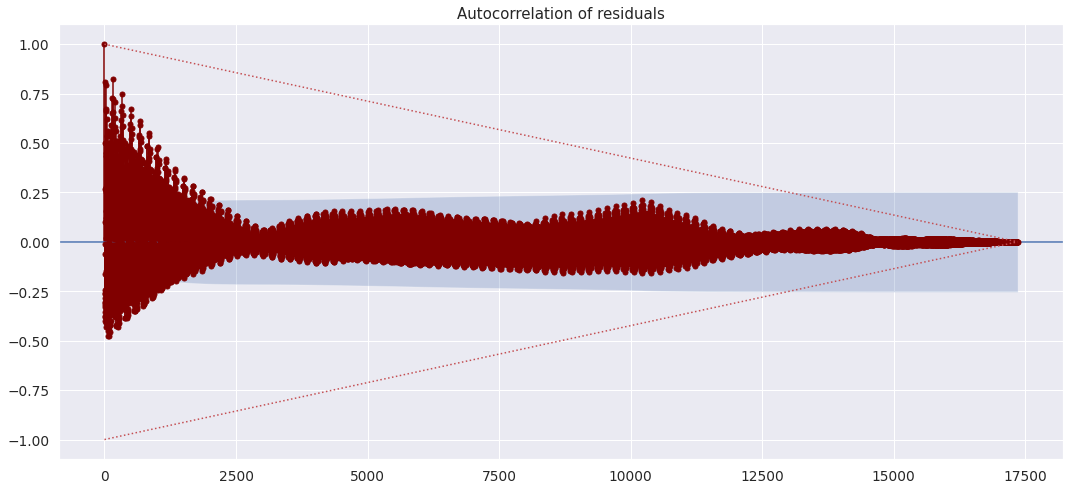

In [ ]:
N = len(df_time['cnt'])
k = np.arange(0, N)
plot_acf(df_time['cnt'], 
         lags=N-1, 
         vlines_kwargs={'color' : 'b'},
         markerfacecolor='b', markeredgecolor='b', 
         title='Autocorrelation of target');
plt.plot(k, 1-k/N, ':r')
plt.plot(k, -1+k/N, ':r')


N = len(trend.dropna())
k = np.arange(0, N)
plot_acf(trend.dropna(), 
         lags=N-1, 
         vlines_kwargs={'color' : 'navy'}, 
         markerfacecolor='navy', markeredgecolor='navy', 
         title='Autocorrelation of trend');


seasonal = decomposition.seasonal
N = len(seasonal)
k = np.arange(0, N)
plot_acf(seasonal, 
         lags=N-1, 
         vlines_kwargs={'color' : 'g'}, 
         markerfacecolor='g', markeredgecolor='g', 
         title='Autocorrelation of seasonal');
plt.plot(k, 1-k/N, ':r')
plt.plot(k, -1+k/N, ':r')


N = len(resid.dropna())
k = np.arange(0, N)
plot_acf(resid.dropna(), 
         lags=N-1,   
         vlines_kwargs={'color' : 'maroon'}, 
         markerfacecolor='maroon', markeredgecolor='maroon', 
         title='Autocorrelation of residuals');
plt.plot(k, 1-k/N, ':r')
plt.plot(k, -1+k/N, ':r')


plt.show()

Periodic signal of the target is weak. It is far away from red triangle.

Trend autocorrelation crosses 0 level only at the point of ~3000.

Seasonal autocorrelation suits the trianle in upper part perfectly. The lower part suits much worse.

Periodicity of residuals is higher than the levele of confidence till the poit of  ~2000.

# Modeling

## Data Splitting and Preprocess

In [ ]:
def timeseries_train_test_split(X, y, test_size):
    test_index = int(len(X)*(1-test_size))
    
    X_train = X[:test_index]
    y_train = y[:test_index]
    X_test = X[test_index:]
    y_test = y[test_index:]
    
    return X_train, X_test, y_train, y_test

In [ ]:
def plot_model_results(y_test, prediction):
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    error = mae(prediction, y_test)
    plt.title(f"Mean absolute error {error}")
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True)
    plt.show()
    
def plot_residuals(y_test, pred):
    errors = y_test - pred

    plt.figure(figsize=(8, 5))
    plt.scatter(list(range(len(errors))),errors)
    plt.title("Distibution of errors")
    plt.ylabel('Error')
    plt.xlabel('Index')
    plt.show()

    plt.figure(figsize=(8, 5))
    plt.scatter(pred,errors)
    plt.title('Relationship of true value vs error (residual analysis)')
    plt.ylabel('Error')
    plt.xlabel('True value')
    plt.show()

    return

def plot_importance(model):
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed')

def cat_preprocess(df):
  cat = ['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit']
  num = ['temp', 'atemp', 'hum', 'windspeed']

  ohe = OneHotEncoder(sparse=False, drop='first')
  df_cat = pd.DataFrame(ohe.fit_transform(df[cat]), index=df.index)
  df_cat.columns = ohe.get_feature_names(cat)

  X_ex = pd.concat([df[num], df_cat], axis=1)
  return X_ex

#### Baseline

In [ ]:
# only endogenous feature
df.index = range(0, len(df))
X_train, X_test, y_train, y_test = timeseries_train_test_split(cat_preprocess(df).iloc[:, 4:-4], df['cnt'], 0.1)

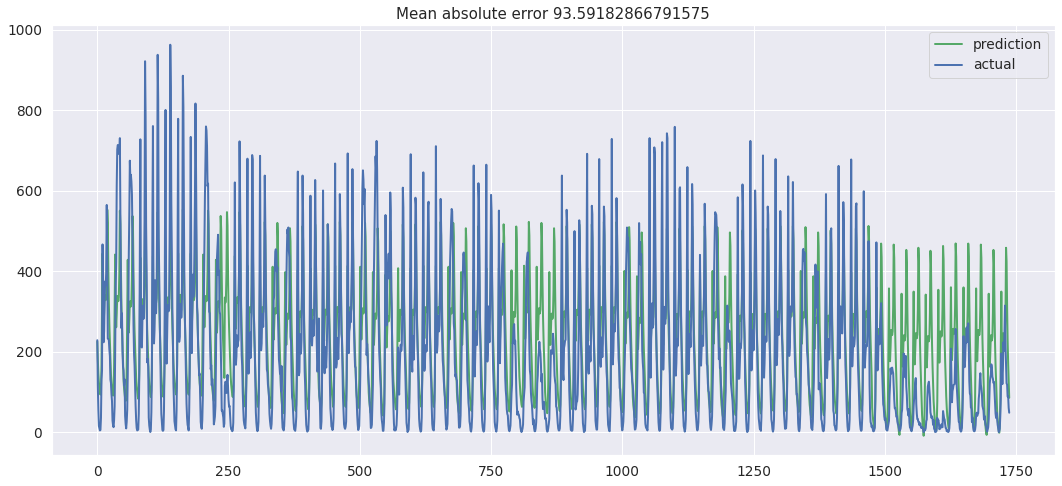

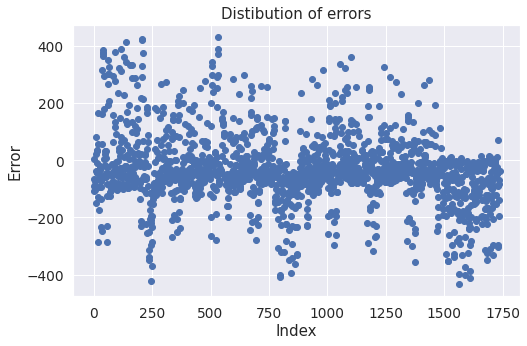

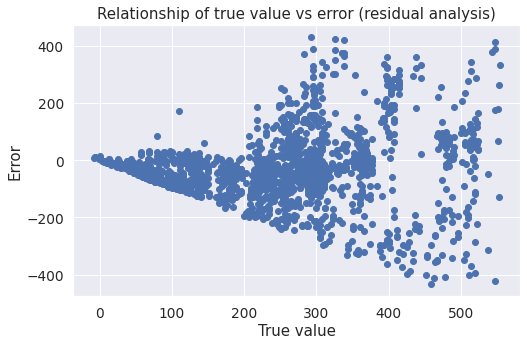

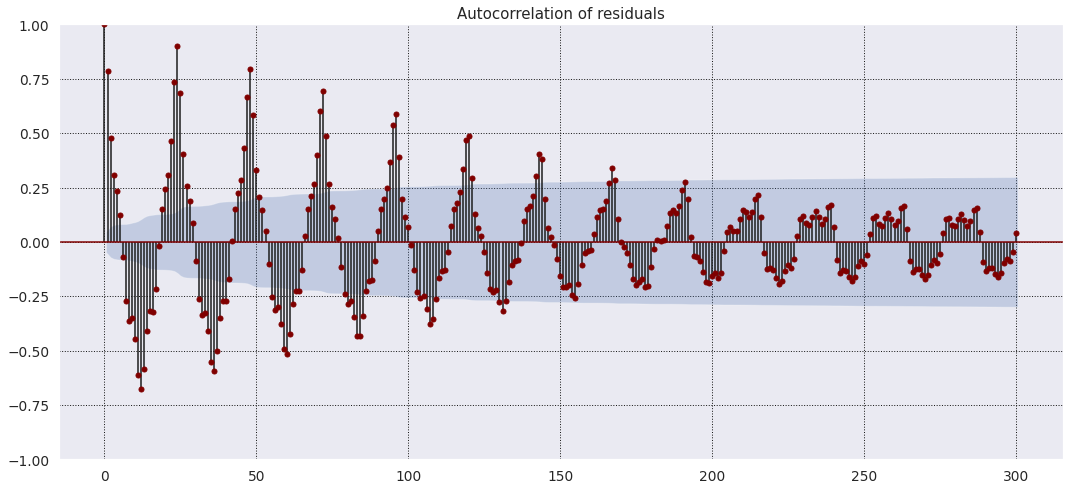

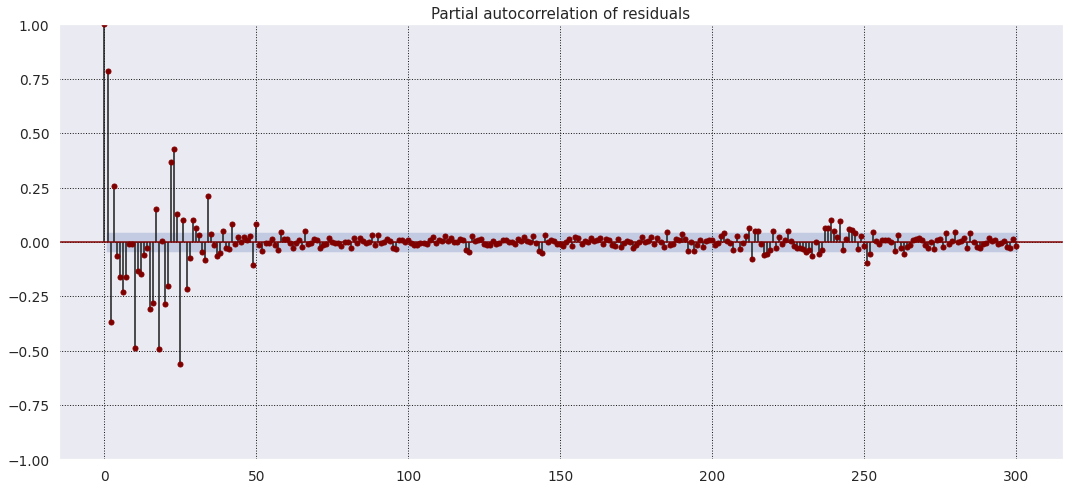

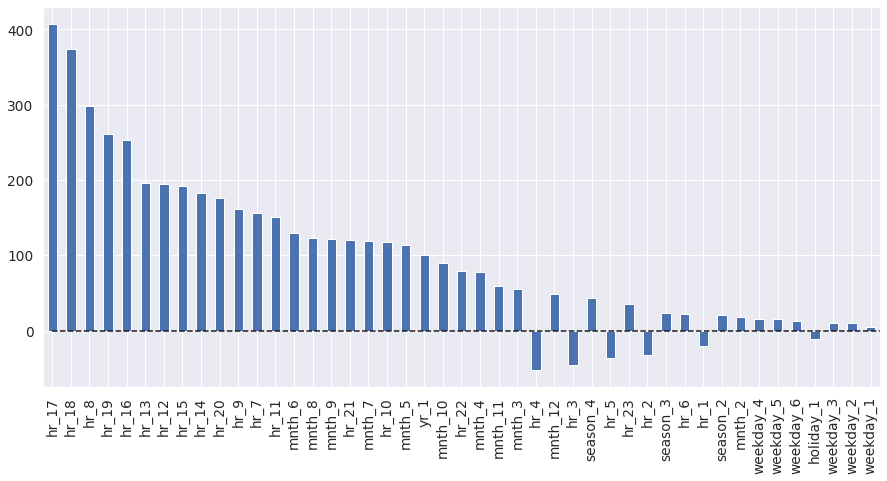

In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)

pred =  lr.predict(X_test)

plot_model_results(y_test, pred)
plot_residuals(y_test, pred)
plot_autocorrelation(pd.Series(pred))
plot_importance(lr)

Unfortunately, residuals do not look like white noise.

It is seen that both residual related graph are separated into 2 parts.
The graph of distribution oferrors depending on the index shows more or less random residues till index = ~1400. After that errors sharply get mostly negative. The reason is on the first graph where we also see that true values differ noticeably before and after index = ~1400. The pattern of target changed dramatically what our model could not expect.

On the "Relation of true value vs error" graph, the behavior of the error changed at the point of true value = 200 after which the dots become more scattered. 


"Hour" feature turns out to be the most important for the regression.

#### Baseline model using results of target decomposition and exogenous features.

In [ ]:
def seasonal_component(ind, period=24):
  seasonal_unit = seasonal[:period].values
  ind_norm = ind % period

  return seasonal_unit[ind_norm]

In [ ]:
df_ex = cat_preprocess(df.drop(['dteday', 'date_time'], axis=1))
X_ex_train = df_ex.iloc[:len(X_train), :]
X_ex_test = df_ex.iloc[len(X_train):, :]

In [ ]:
decomposition = seasonal_decompose(df_time[:len(X_train)], model='additive', period=24)
trend = decomposition.trend
seasonal = decomposition.seasonal

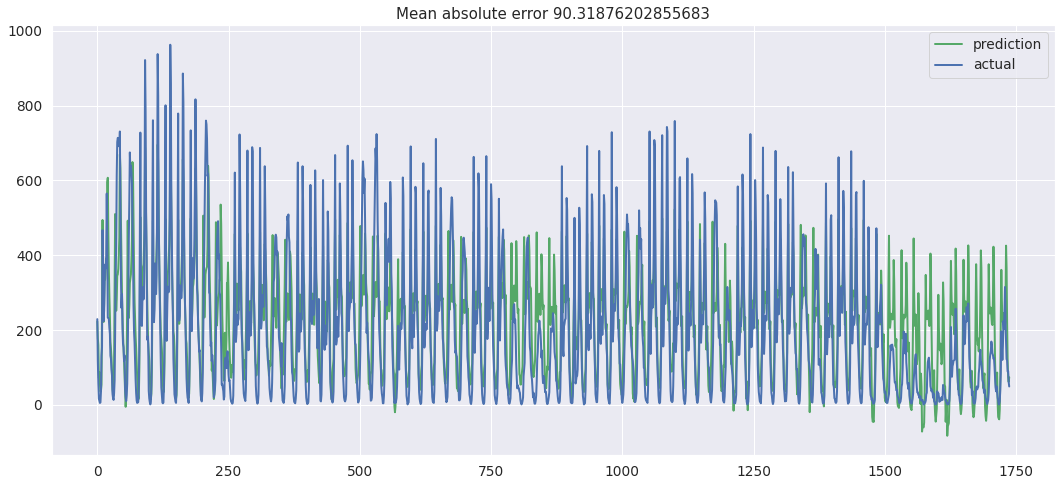

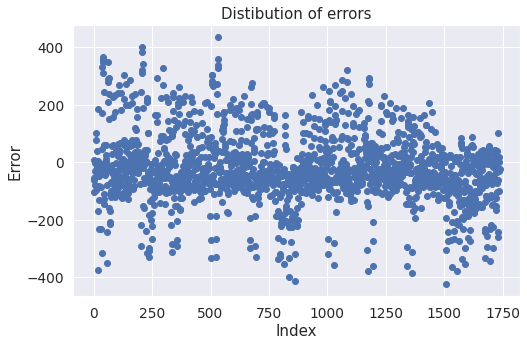

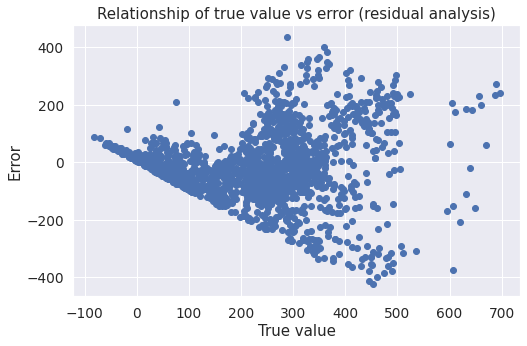

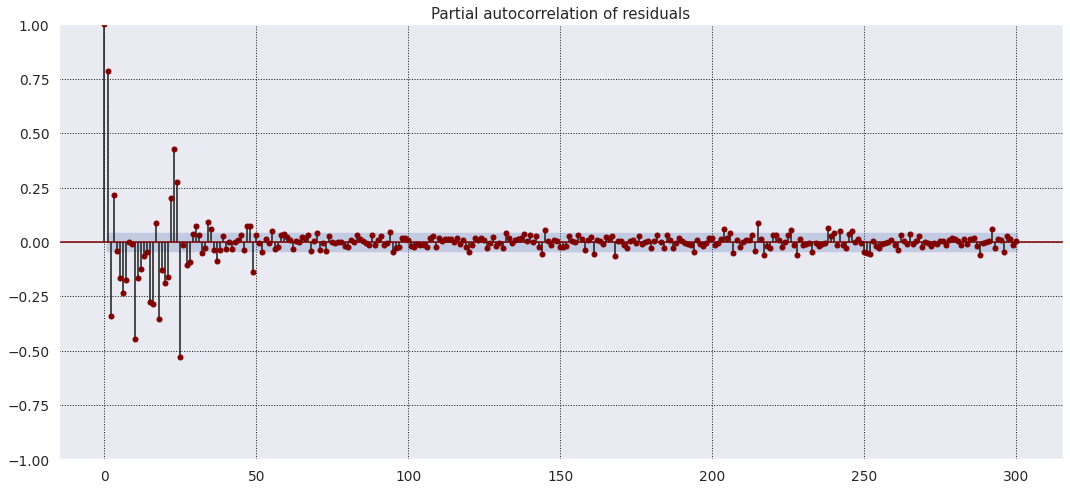

In [ ]:
lr_ex = LinearRegression()
lr_ex.fit(X_ex_train, y_train)

pred = lr_ex.predict(X_ex_test) + seasonal_component(X_ex_test.index)

plot_model_results(y_test, pred)
plot_residuals(y_test, pred)
plot_autocorrelation(pd.Series(pred))

The score impoved, but not much.

Residual graphs look the same as for baseline.

### ARIMA

In [ ]:
test_index = int(len(df_time)*0.9)

train = df_time[:test_index]
train['cnt'] = pd.Series(train['cnt'], index=train.index)
train.dropna(inplace=True)

test = df_time[test_index:]
test['cnt'] = pd.Series(test['cnt'], index=test.index)

In [ ]:
arima = pm.auto_arima(train['cnt'], error_action='ignore', trace=True,
                      suppress_warnings=True, maxiter=5,
                      seasonal=True,  start_p=12, max_p=12,
                      start_q=24, max_q=25, d=1, with_intercept=False)

Performing stepwise search to minimize aic
 ARIMA(12,1,24)(0,0,0)[0]             : AIC=176061.139, Time=39.32 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=188566.370, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=187073.714, Time=0.34 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=186126.885, Time=0.88 sec
 ARIMA(11,1,24)(0,0,0)[0]             : AIC=176072.998, Time=38.61 sec
 ARIMA(12,1,23)(0,0,0)[0]             : AIC=177902.775, Time=40.70 sec
 ARIMA(12,1,25)(0,0,0)[0]             : AIC=176063.872, Time=46.49 sec
 ARIMA(11,1,23)(0,0,0)[0]             : AIC=177916.341, Time=40.31 sec
 ARIMA(11,1,25)(0,0,0)[0]             : AIC=176047.932, Time=49.82 sec
 ARIMA(10,1,25)(0,0,0)[0]             : AIC=176070.475, Time=44.22 sec
 ARIMA(10,1,24)(0,0,0)[0]             : AIC=176116.718, Time=38.06 sec
 ARIMA(11,1,25)(0,0,0)[0] intercept   : AIC=176050.063, Time=111.55 sec

Best model:  ARIMA(11,1,25)(0,0,0)[0]          
Total fit time: 450.534 seconds


In [ ]:
pred = arima.predict(n_periods=test.shape[0])

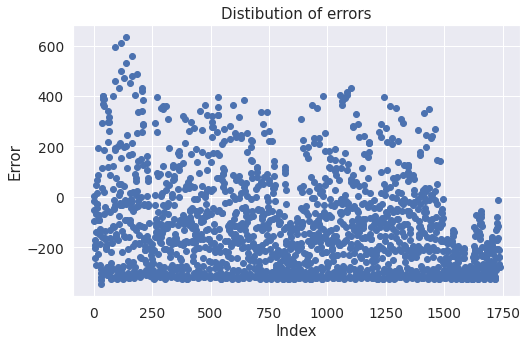

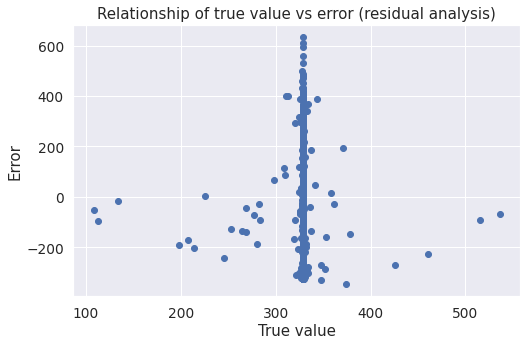

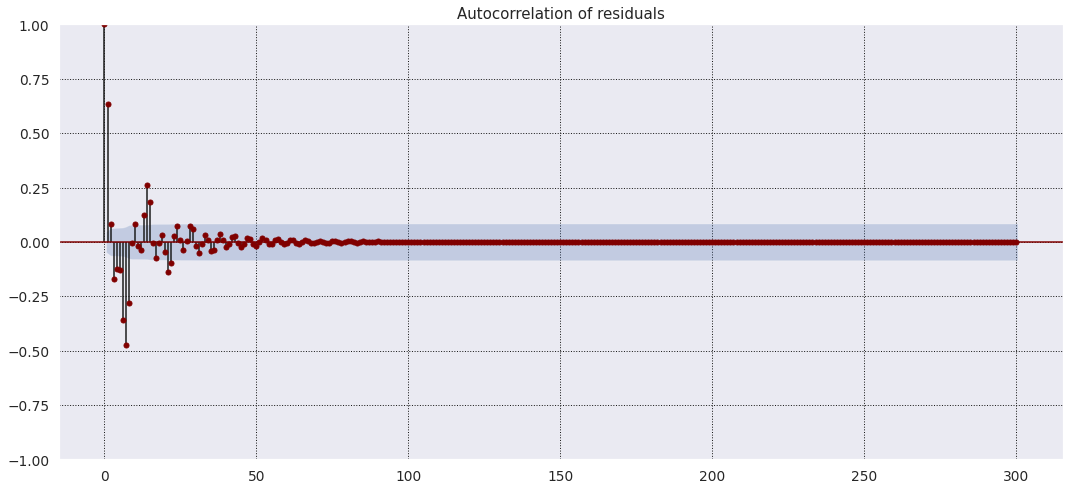

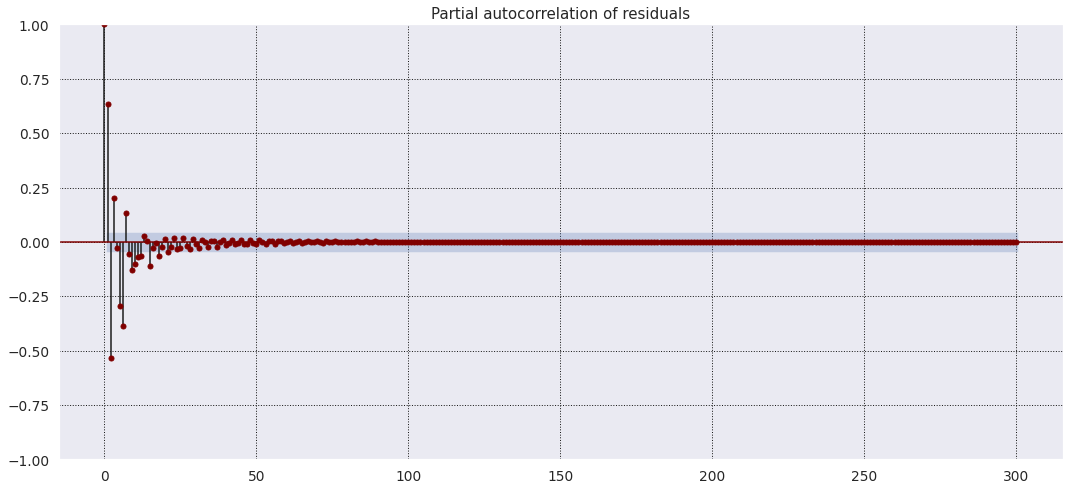

In [ ]:
plot_model_results(y_test, pred)
plot_residuals(y_test, pred)
plot_autocorrelation(pd.Series(pred))

ARIMA catches only a few first samples, after with tourns into almost a constant.
I have tried different parameters, but in most cases Colab just crashed in the middle of performing :(
  I was trying to use arima from statsmodel, but I was waiting for it for like 5 hours and it had not finished yet, so colab crushed because of long time.
I really have no clue how to deal with it...

From the first predicts' residuals, however, a periodic pattern is observed.

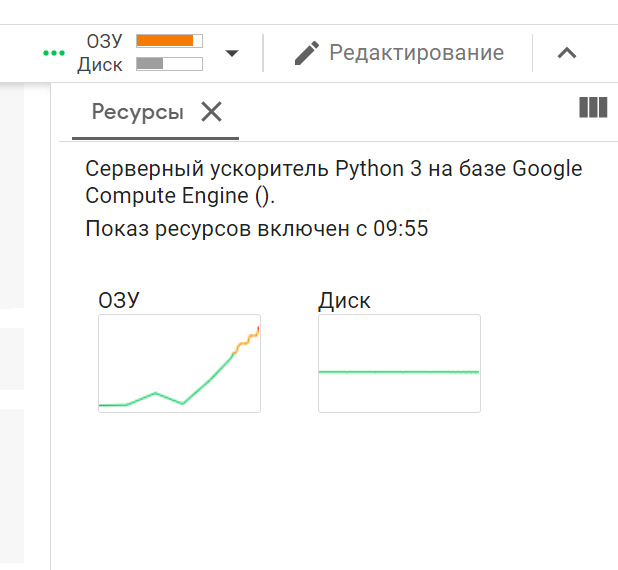

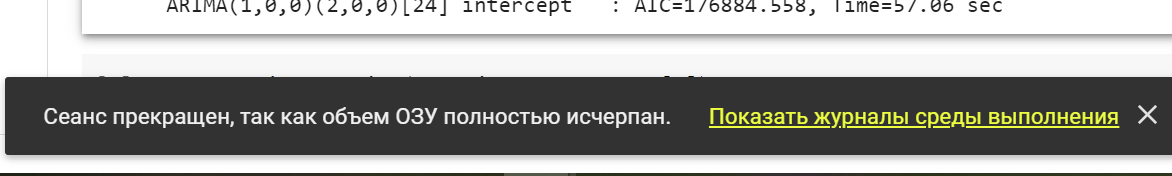

### SARIMAX

In [ ]:
import statsmodels.api as sm

In [ ]:
train.index = X_ex_train.index

In [ ]:
sarimax = sm.tsa.statespace.SARIMAX(train['cnt'],
                                    X_ex_train,
                                    order=(11, 1, 24),
                                    seasonal_order=(11, 1, 24, 24),
                                    enforce_stationarity=False,
                                    enforce_invertibility=False).fit()

In [ ]:
pred = sarimax.predict(train.index[-1], test.index[-1], exog=X_ex_test)[1:]
plot_model_results(y_test, pred)
plot_residuals(y_test, pred)
plot_autocorrelation(pred)

All the same problems with sarimax. I have created it, but could not get any results because of colab RAM limits.

Maybe I do something completely wrong...

### Prophet

In [ ]:
train = pd.DataFrame([train.index.values, train['cnt']], index=['ds', 'y']).T
test = pd.DataFrame([test.index.values, test['cnt']], index=['ds', 'y']).T


In [ ]:
pr_model = Prophet(daily_seasonality=True, 
                   yearly_seasonality=True, 
                   weekly_seasonality=False).add_seasonality(name='daily', period=1, fourier_order=15)
pr_model.fit(train)

In [ ]:
future = pd.DataFrame(test['ds'])

In [ ]:
pred = pr_model.predict(future)['yhat']

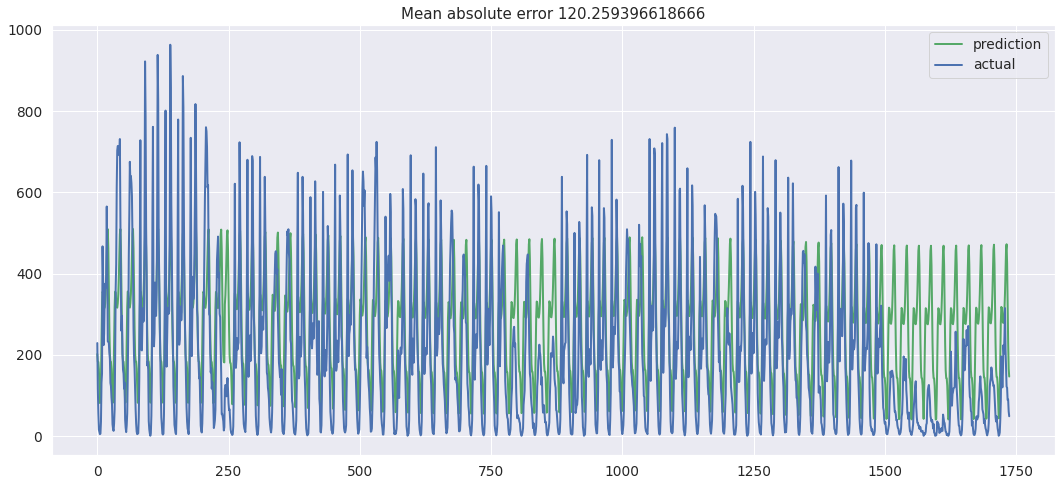

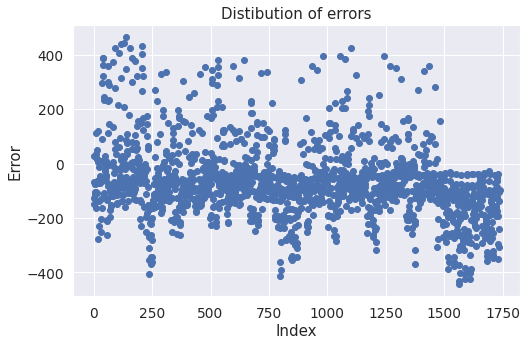

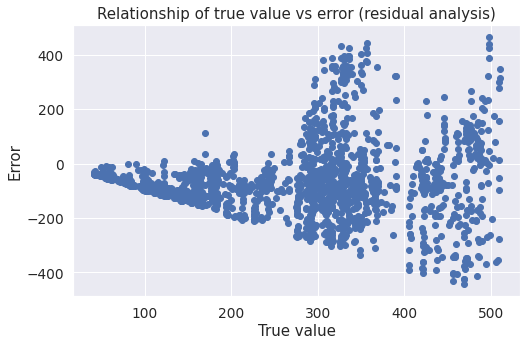

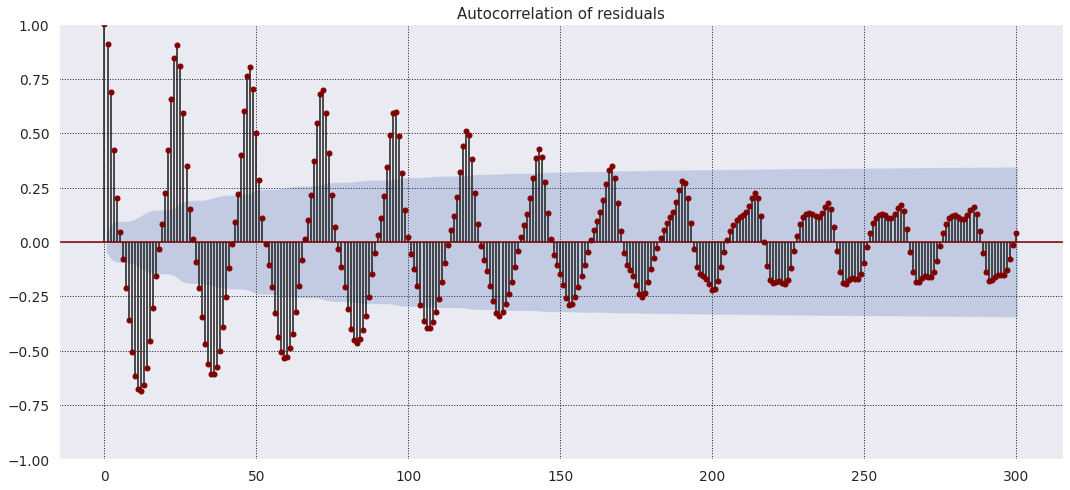

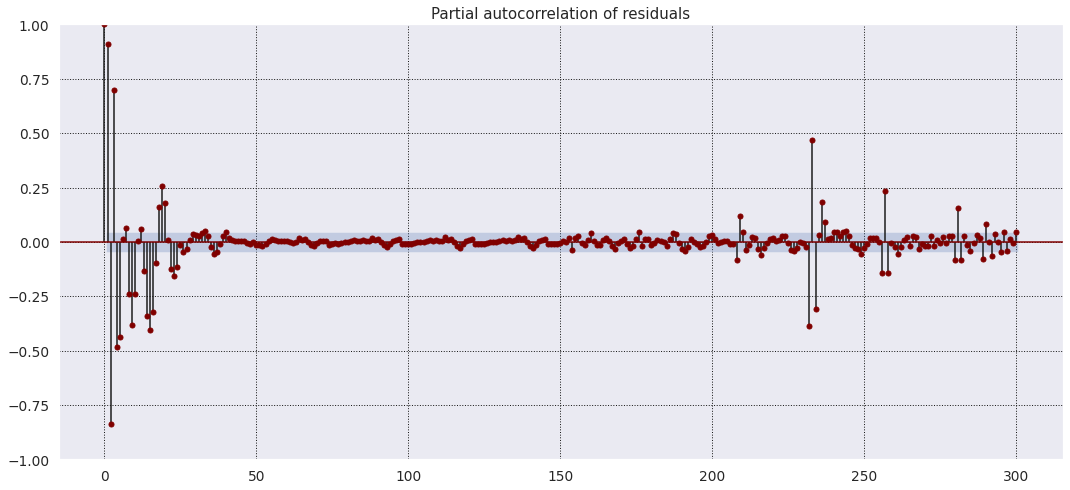

In [ ]:
plot_model_results(y_test, pred)
plot_residuals(np.array(y_test), np.array(pred))
plot_autocorrelation(pred)

God bless Prophet and thanks for successful fitting at least one model in this home task!

Same as for baseline, the range of errors increases over time. At the end of the observed time interval, the behavior of the values ​​changes sharply, due to which the model suddenly begins to err more strongly.

### CatBoostRegressor

I have decided to improve baseline by applying some advanced regression models.

In [ ]:
cat_df = df.iloc[:, 1:-4]
cat_y = df['cnt']

X_train, X_test, y_train, y_test = timeseries_train_test_split(cat_df, cat_y, 0.1)

In [ ]:
best_cat_params = {'cat_features': [0, 1, 2, 3, 4, 5, 6],
 'depth': 10,
 'iterations': 260,
 'l2_leaf_reg': 0.5,
 'learning_rate': 0.2,
 'loss_function': 'MAE'}  # precomputed from "advanced regression" homework


cat_b = CatBoostRegressor(**best_cat_params)
cat_b.fit(X_train, y_train)
pred = cat_b.predict(X_test) + seasonal_component(X_ex_test.index)

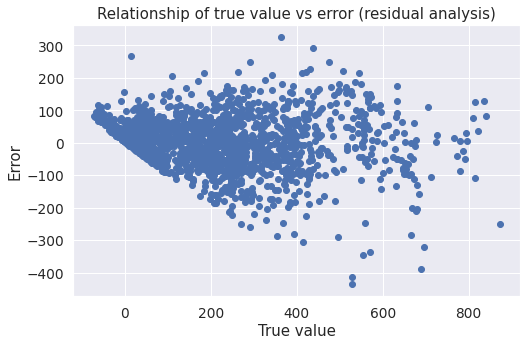

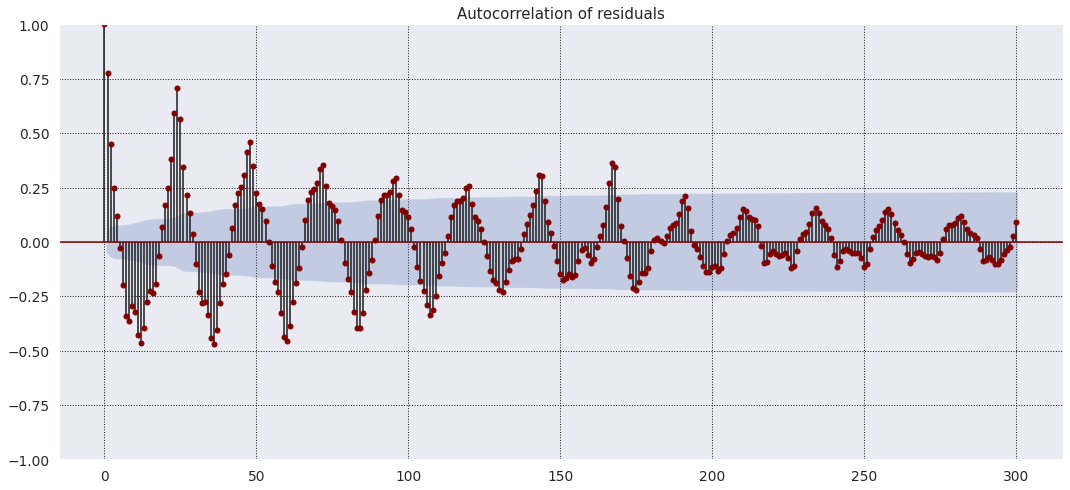

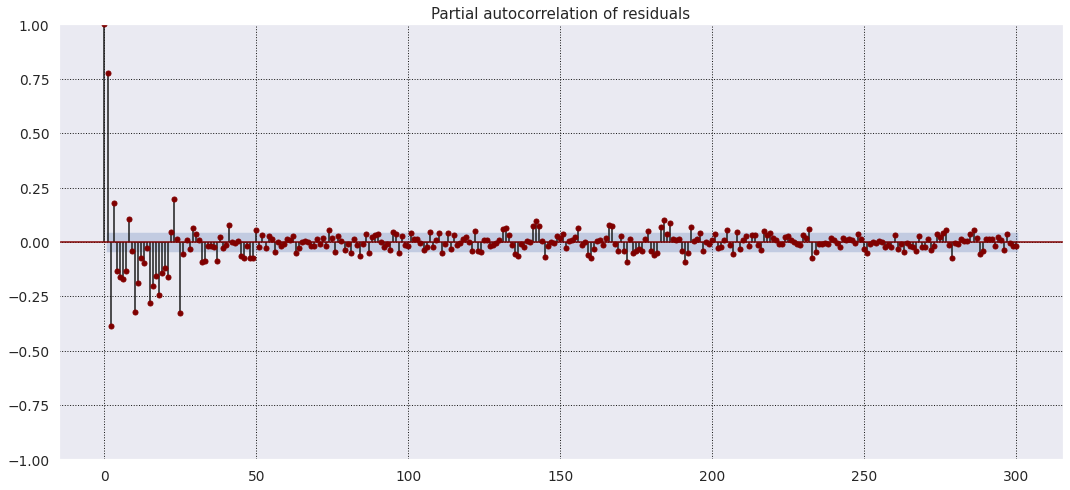

In [ ]:
plot_model_results(y_test, pred)
plot_residuals(y_test, pred)
plot_autocorrelation(pd.Series(pred))

For now, this score is the best. I have even suspected data leak somewhere, but after inspection could not find anything.

Residual analysis shws the same problems as for all other models that I have already described. However, in the point of sharp change, the error's growth remans stable in contrast to the previous modes, where there was a noticeable change in the residual graphs.

Negative values, which I also earlier have mentioned, are also observed.

Autocorrelation of residuals also didn't changed. The periodic pattern is still strong.

# Conclusion

About the data: from EDA, data is considered as non-stationary with seasonal component 24 hours.
It was not possible for me to extract the seasonal component in full.

About predicting:

It was a long way... 

Across time series specific algorithms prophet leads because it is the only one which succeeded, unfortunately.
A big disadvantage of these models is the cost and time of its fitting.

Basic and advanced regressors showed good results when adding a seasonal component from decomposition.

Comparing to the result from "Advanced regression" section provided on the picture, I can say that linear regression showed good results in both cases.
Catboost was improved a lot by adding seasonal component. On the picture, "Catboost" stands for CatBoostRegressor with shuffling, "Catboost_yearly" stands for CatBoostRegressor fitted on the 2011 and tested on 2012.

REsidual analysis showed, that for all models' residuals experienced heteroscedasticity which grew in the most cases in december 2012, where the behaivor of true values changes dramatically.

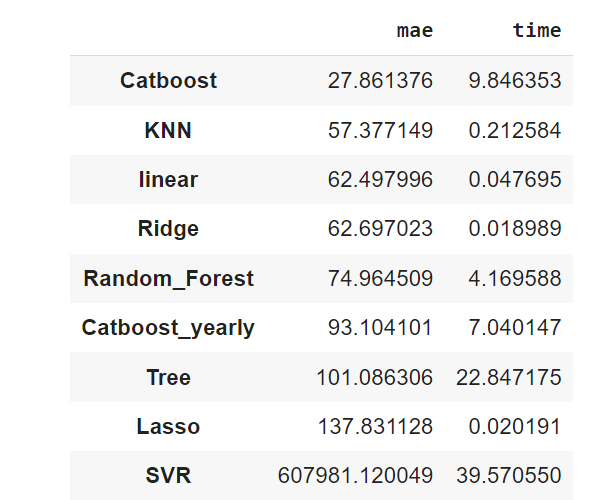